In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [20]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [21]:
import pandas as pd

# Calculate the correct test size for an 85-15 split
desired_test_size = int(0.15 * (len(train_df) + len(test_df)))

# If test_df is larger than desired size, move some rows back to train_df
if len(test_df) > desired_test_size:
    move_size = len(test_df) - desired_test_size  # Excess rows in test_df
    move_rows = test_df.sample(n=move_size, random_state=42)

    # Move the excess rows back to train_df
    test_df = test_df.drop(move_rows.index)
    train_df = pd.concat([train_df, move_rows], ignore_index=True)

# Print the final sizes
print(f"New Train Size: {len(train_df)}")
print(f"New Test Size: {len(test_df)}")

# Verify the ratio
total_size = len(train_df) + len(test_df)
print(f"Train-Test Ratio: {len(train_df) / total_size:.2f} - {len(test_df) / total_size:.2f}")


New Train Size: 93030
New Test Size: 16416
Train-Test Ratio: 0.85 - 0.15


In [22]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



187
0    77013
4     6834
2     6135
1     2364
3      684
Name: count, dtype: int64


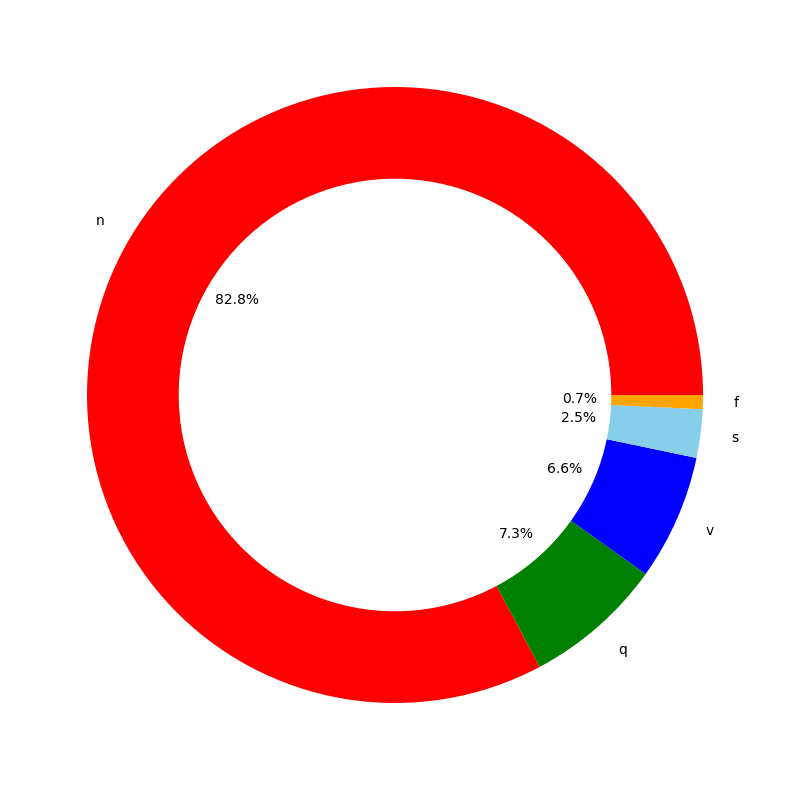

In [23]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

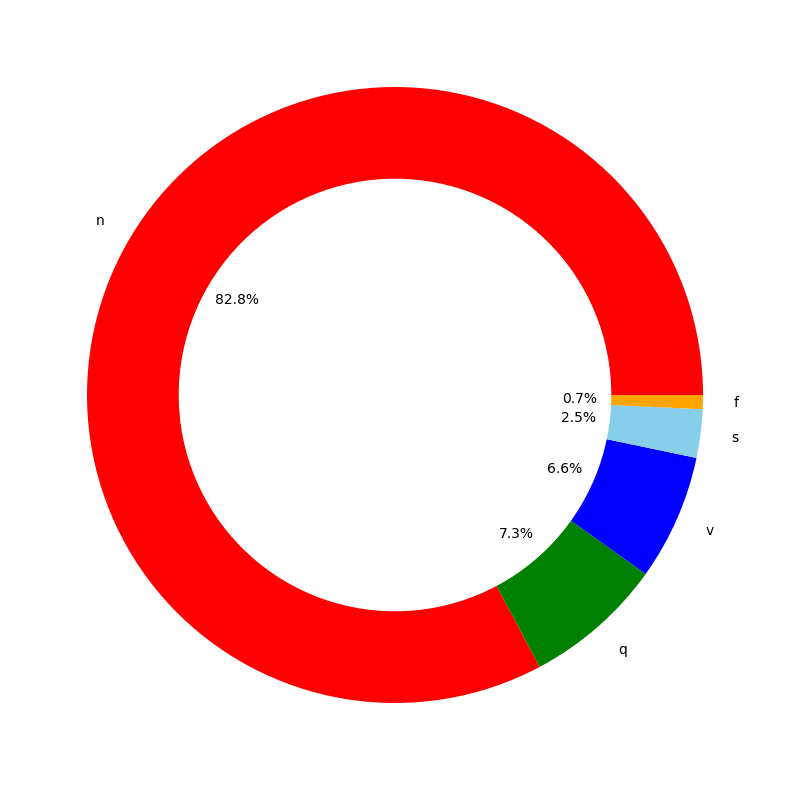

In [24]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [25]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

Text(0.5, 1.0, 'Non-ecotic beats')

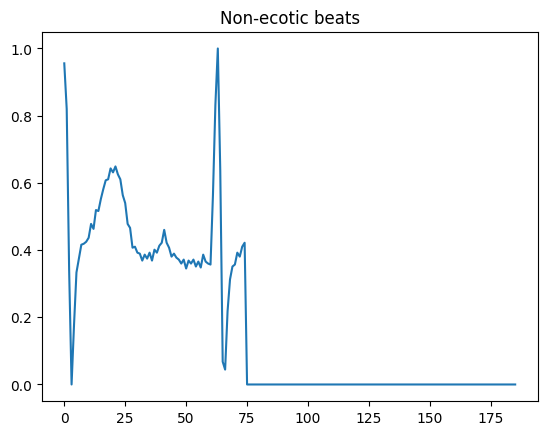

In [26]:
plt.plot(c.iloc[0,:186])

plt.title('Non-ecotic beats')


Text(0.5, 1.0, 'Supraventricular ectopic beats')

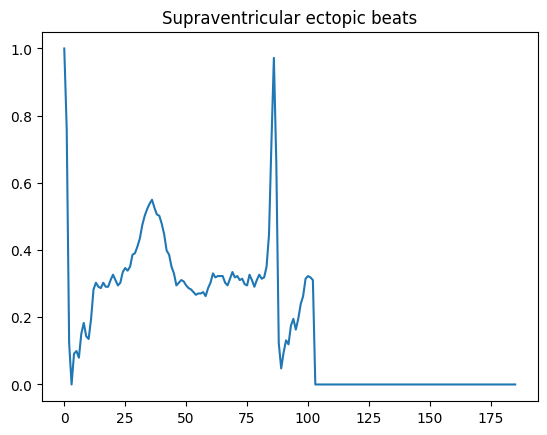

In [27]:
 plt.plot(c.iloc[1,:186])
plt.title('Supraventricular ectopic beats')

Text(0.5, 1.0, 'Ventricular ectopic beats')

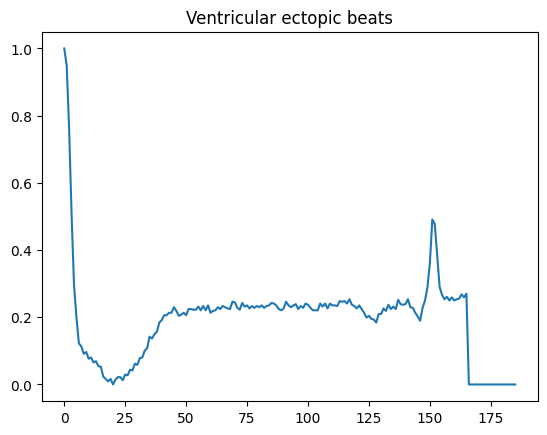

In [28]:
 plt.plot(c.iloc[2,:186])
plt.title('Ventricular ectopic beats')

Text(0.5, 1.0, 'Fusion beats')

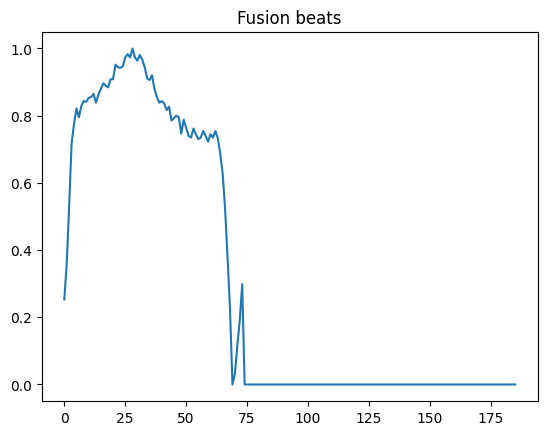

In [29]:
plt.plot(c.iloc[3,:186])
plt.title('Fusion beats')


Text(0.5, 1.0, 'Unknown beats')

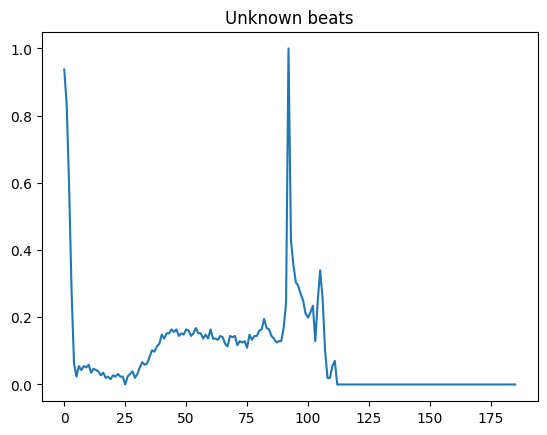

In [30]:
plt.plot(c.iloc[4,:186])
plt.title('Unknown beats')


In [31]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [32]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [33]:
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Train data shape: (93030, 186, 1), (93030, 5)
Test data shape: (16416, 186, 1), (16416, 5)


In [34]:
train_ratio = len(X_train) / (len(X_train) + len(X_test))
test_ratio = len(X_test) / (len(X_train) + len(X_test))

print(f"Train-Test Split Ratio: {train_ratio:.2f} - {test_ratio:.2f}")


Train-Test Split Ratio: 0.85 - 0.15


In [35]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping

def network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_cnn = Input(shape=im_shape, name='inputs_cnn')
    conv1_1 = Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)

    pool1 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1 = Convolution1D(64, (3), activation='relu', padding="same")(pool1)
    conv2_1 = BatchNormalization()(conv2_1)

    pool2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1 = Convolution1D(64, (3), activation='relu', padding="same")(pool2)
    conv3_1 = BatchNormalization()(conv3_1)

    pool3 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    conv4_1 = Convolution1D(128, (3), activation='relu', padding="same")(pool3)
    conv4_1 = BatchNormalization()(conv4_1)

    pool4 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)

    conv5_1 = Convolution1D(128, (3), activation='relu', padding="same")(pool4)
    conv5_1 = BatchNormalization()(conv5_1)

    pool5 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv5_1)

    conv6_1 = Convolution1D(128, (3), activation='relu', padding="same")(pool5)
    conv6_1 = BatchNormalization()(conv6_1)
    pool6 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv6_1)

    conv7_1 = Convolution1D(256, (3), activation="relu", padding="same")(pool6)
    conv7_1 = BatchNormalization()(conv7_1)
    pool7 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv7_1)

    flatten = Flatten()(pool7)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)

    model = Model(inputs=inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8)]

    history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))

    return model, history


In [36]:
def evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    # Get predictions
    y_pred = model.predict(X_test)

#     return y_pred, scores[1]  # Returning y_pred along with accuracy
#     return scores[1]

In [37]:

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
# from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, BatchNormalization

model,history=network(X_train,y_train,X_test,y_test)



Epoch 1/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9440 - loss: 0.2015 - val_accuracy: 0.9703 - val_loss: 0.1136
Epoch 2/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9763 - loss: 0.0815 - val_accuracy: 0.9776 - val_loss: 0.0879
Epoch 3/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9813 - loss: 0.0621 - val_accuracy: 0.9722 - val_loss: 0.1076
Epoch 4/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9845 - loss: 0.0533 - val_accuracy: 0.9817 - val_loss: 0.0614
Epoch 5/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9870 - loss: 0.0408 - val_accuracy: 0.9850 - val_loss: 0.0606
Epoch 6/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9881 - loss: 0.0376 - val_accuracy: 0.9856 - val_loss: 0.0555
Epoch 7/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9851 - val_loss: 0.0530
Epoch 8/20
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9909 - loss: 0

In [38]:
# Extract the highest accuracy from training history
best_accuracy = max(history.history['accuracy'])  # If you want training accuracy
best_val_accuracy = max(history.history.get('val_accuracy', [0]))  # For validation accuracy

print(f"Highest Training Accuracy: {best_accuracy:.4f}")
print(f"Highest Validation Accuracy: {best_val_accuracy:.4f}")


Highest Training Accuracy: 0.9947
Highest Validation Accuracy: 0.9871


In [41]:
best_accuracy = max(history.history['accuracy'])  # If you want training accuracy
best_val_accuracy = max(history.history.get('val_accuracy', [0]))  # For validation accuracy

print(f"Highest Training Accuracy: {best_accuracy:.4f}")
print(f"Highest Validation Accuracy: {best_val_accuracy:.4f}")


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predictions on the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoding to class labels

# Convert one-hot encoded y_test back to class labels if needed
if len(y_test.shape) > 1:  # Check if it's one-hot encoded
    y_test = np.argmax(y_test, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Compute Metrics
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

# Print Metrics
print(f"✅ Test Accuracy: {best_val_accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")

# Display Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("Confusion_Matrix.png")
plt.show()


Highest Training Accuracy: 0.9947
Highest Validation Accuracy: 0.9871
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Test Accuracy: 0.9871
✅ F1-Score: 0.9869
✅ Precision: 0.9868
✅ Recall: 0.9871
